# Network Tour project

This is a notebook to describe the connections between artists and users.

## Analysis on data

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import pandas as pd
import os.path
import networkx as nx
import scipy.sparse as sp
import sklearn as skl
import pygsp as gsp
import copy
from Dataset import Dataset
%matplotlib inline
from plotly.graph_objs import *

Loading the artists information, user/friend connections, and user/artist listening count.

In [2]:
# Define paths of the files
data_folder = os.path.join('.','data')
artists_path = os.path.join(data_folder,'artists.dat')
ratings_path = os.path.join(data_folder,'user_artists.dat')
tags_path = os.path.join(data_folder,'tags.dat')
tags_assign_path = os.path.join(data_folder,'user_taggedartists-timestamps.dat')
friendship_path = os.path.join(data_folder, 'user_friends.dat')

In [3]:
artists_df = pd.read_csv(artists_path, sep='\t', header=0,index_col=0, skipinitialspace=True)
user_artist = pd.read_csv(ratings_path, sep='\t', header=0, skipinitialspace=True)
user_user = pd.read_csv(friendship_path, sep='\t', header=0,  skipinitialspace=True)

In [4]:
artists_df.head()

,name,url,pictureURL
id,,,
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [5]:
artists_df.isnull().sum()

name            0
url             0
pictureURL    444
dtype: int64

In [6]:
print("Are the artists names unique?" ,artists_df['name'].is_unique)
print("Number of artists in the dataset:", len(artists_df))

Are the artists names unique? True
Number of artists in the dataset: 17632


In [7]:
user_artist.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [8]:
user_artist.isnull().sum()

userID      0
artistID    0
weight      0
dtype: int64

In [9]:
user_user.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [10]:
user_user.isnull().sum()

userID      0
friendID    0
dtype: int64

In [11]:
max_user_weight = user_artist.groupby('userID').max()
max_user_weight.describe()

,artistID,weight
count,1892.000000,1892.000000
mean,10749.308668,8854.966173
std,4882.704028,23090.244867
min,89.000000,1.000000
25%,6853.750000,1059.500000
50%,11039.500000,2690.000000
75%,14899.250000,6928.500000
max,18745.000000,352698.000000


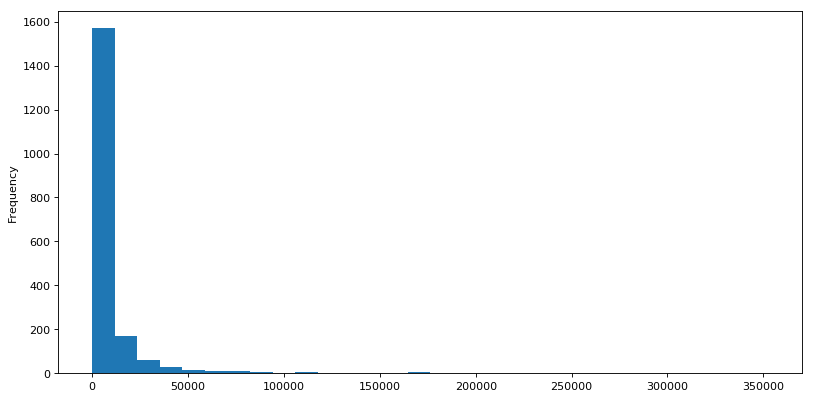

In [16]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
max_user_weight['weight'].plot.hist(bins=30)

We can see from the plot above that most of the users have a maximum listening count of less than 50,000.

In [17]:
print("The number of users with less than a maximum of 50,000 listening count:",\
      len(max_user_weight.loc[max_user_weight['weight']<=50000]))
percentage = len(max_user_weight.loc[max_user_weight['weight']<=50000])/ len(max_user_weight)*100
print("Percentage of total users:", \
     percentage ,"%")

The number of users with less than a maximum of 50,000 listening count: 1833
Percentage of total users: 96.8816067653277 %


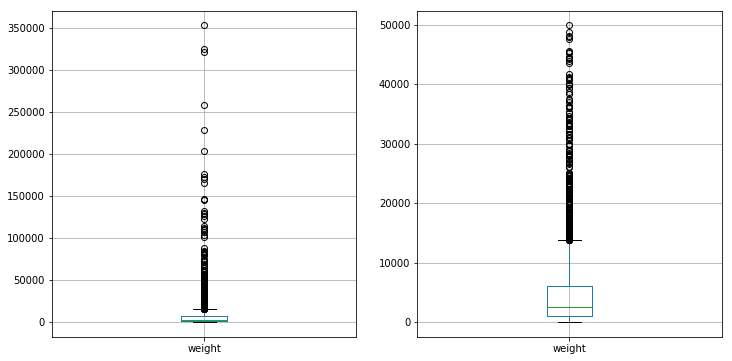

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plt.subplot(1, 2, 1)
max_user_weight.boxplot(column='weight')
plt.subplot(1,2,2)
max_user_weight.loc[max_user_weight['weight']<=50000].boxplot(column='weight')

In [19]:
user_user.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [20]:
print("Number of users in the dataset:", len(set(user_user.userID.values)))
print("Number of edges between users: ", int(len(user_user)/2))

Number of users in the dataset: 1892
Number of edges between users:  12717


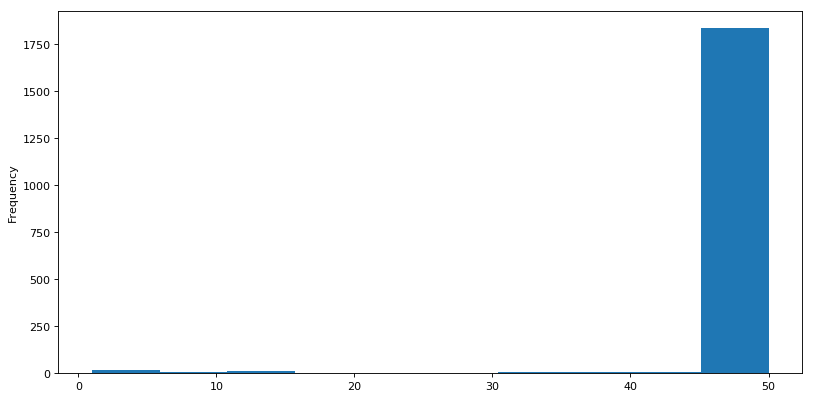

In [14]:
number_user_artist = user_artist.groupby('userID').nunique().artistID.to_frame()
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
number_user_artist['artistID'].plot.hist(bins=10)

We can clearly see that most of the users have between 45 and 50 artists, in fact a further analysis shows that most of those users have exactly 50 artists. To make the data more consistent, we will only use those.

In [15]:
print("The number of users with exactly 50 artists: ",\
      len(number_user_artist.loc[number_user_artist['artistID']==50]))
percentage = len(number_user_artist.loc[number_user_artist['artistID']==50])/ len(number_user_artist)*100
print("Percentage of those users:", \
     percentage ,"%")

The number of users with exactly 50 artists:  1829
Percentage of those users: 96.67019027484145 %


Number of connections of each artist.

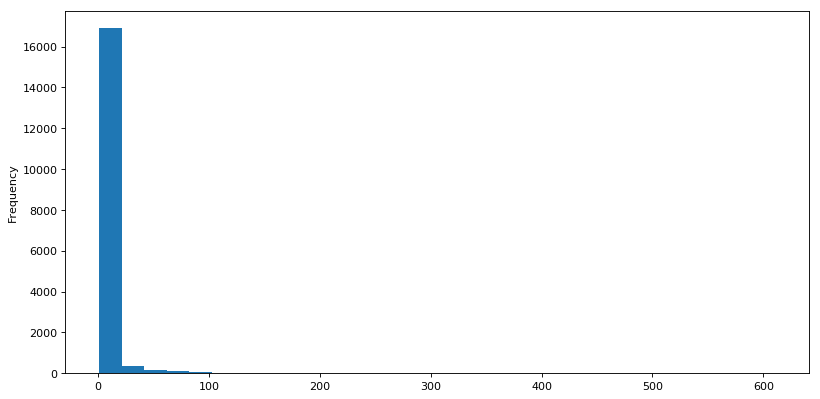

In [23]:
number_artist_user = user_artist.groupby('artistID').nunique().userID.to_frame()
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
number_artist_user['userID'].plot.hist(bins=30)

In [24]:
print("The number of artists in the dataset: ", len(number_artist_user))
print("The number of artists with less than 50 user connections:", \
      len(number_artist_user[number_artist_user['userID']<50]))
percentage = len(number_artist_user[number_artist_user['userID']<50]) / len(number_artist_user) *100
print("Percentage of those artists :", \
     percentage ,"%")

The number of artists in the dataset:  17632
The number of artists with less than 50 user connections: 17309
Percentage of those artists : 98.16810344827587 %


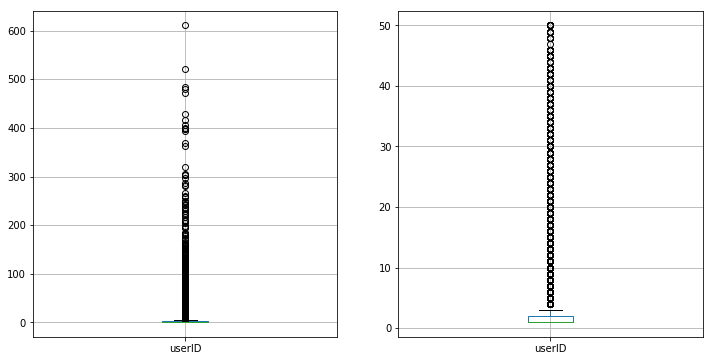

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plt.subplot(1, 2, 1)
number_artist_user.boxplot(column='userID')
plt.subplot(1,2,2)
number_artist_user.loc[number_artist_user['userID']<=50].boxplot(column='userID')

In [26]:
len(number_artist_user.loc[number_artist_user['userID']==1])

10679

In [27]:
user_user_group = user_user.groupby('userID').nunique().friendID.to_frame()

Distribution of the number of friends each user have.

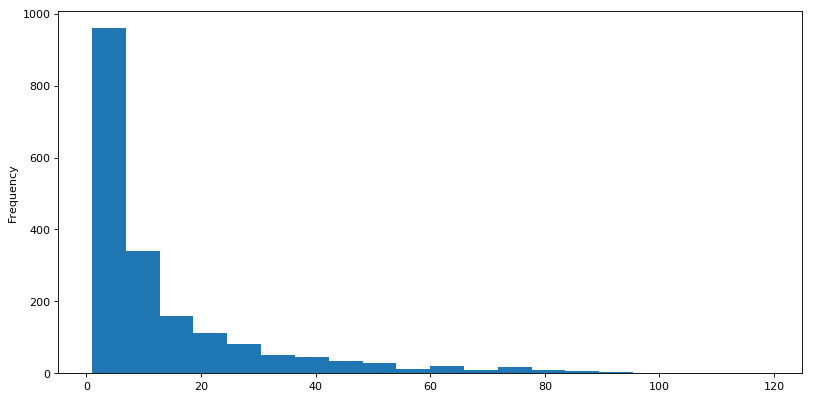

In [29]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
user_user_group['friendID'].plot.hist(bins=20)

In [36]:
users_to_drop = set()

# Group ratings based on users
group = user_artist.groupby('userID')

# Drop users with too high max weight (looking at the distribution
# they seems to be outliers)
data = group.max()
users_to_drop.update(data[data.weight > 50000].index)

# Drop users with few artists
data = group.nunique().artistID
users_to_drop.update(data[data < 49].index)

print(len(users_to_drop), ' users dropped')

117  users dropped


In [39]:
user_artist_ref = user_artist[~user_artist.userID.isin(users_to_drop)]
user_user_ref = user_user[~user_user.userID.isin((users_to_drop))]
user_user_ref = user_user_ref[~user_user_ref.friendID.isin(users_to_drop)]

first_users = set(user_user_ref.userID.values)
users_in_artists = set(user_artist_ref.userID.values)
difference_in_users = list(users_in_artists - first_users)

print("Number of users not in our user network:", len(difference_in_users))

user_artist_ref = user_artist_ref[~user_artist_ref.userID.isin(difference_in_users)]
user_user_ref = user_user_ref[~user_user_ref.userID.isin((difference_in_users))]
user_user_ref = user_user_ref[~user_user_ref.friendID.isin(difference_in_users)]

# Update ID translator dictionaries
userID2POS = {i:p for p,i in enumerate(set(user_artist_ref.userID))}
userPOS2ID = {p:i for p,i in enumerate(set(user_artist_ref.userID))}

Number of users not in our user network: 26


In [40]:
len(user_artist_ref)

87448

In [41]:
len(user_artist)

92834

In [42]:
len(user_user)

25434

In [43]:
len(userID2POS)

1749

In [297]:
graph = nx.Graph()

In [326]:
friend_friend = np.zeros((len(userID2POS),len(userID2POS)))
for index, row in user_user_ref.iterrows():
    upos1 = userID2POS[row.userID]
    upos2 = userID2POS[row.friendID]
    friend_friend[upos1,upos2] = 1
    graph.add_edge(upos1, upos2, weight=1)

In [263]:
len(user_user_ref)/2

10741.0

In [264]:
sum(sum(i > 0 for i in friend_friend))/2

10741.0

In [316]:
# generates a lists of stubs that correspond to the current degree_distribution
def generate_stubs(g):
    """Generates lists of stubs containing `d` stubs for each node, where `d` is the degree of the node."""
    stubs_array = np.array([], dtype=np.int32)
    # adds num_of_stubs stubs for every node index according to its degree 
    index_degree_pairs = sorted(list(dict(nx.degree(g)).items()), key=lambda x: x[0])
    for ind, num_stubs in index_degree_pairs:
        if num_stubs != 0:
            stubs_array = np.append(stubs_array, ([ind]*num_stubs))
    np.random.shuffle(stubs_array)
    return stubs_array

def get_max_pair(pairs):
    """Returns the index-degree pair, corresponding to the element with at most stubs."""
    pair = sorted(pairs, key=lambda x: x[1], reverse=True)[0]
    if pair[1] == 0:
        return None
    return pair

def greedy_configuration(g):
    """Generates a random graph with degree distribution as close as possible to the graph passed as 
    argument to the function."""
    stubs = generate_stubs(g)
    graph = nx.empty_graph()
    pairs = dict(nx.degree(g)) # index-degree pairs
    highest = get_max_pair(list(pairs.items()))

    # Used to keep up with the number of processed stubs in every moment
    total = sum([p[1] for p in list(pairs.items())])/2 
    processed = 0

    while highest != None:
        source = highest[0] # the node that is the source in this itteration

        # delete the stubs that correspond to the stubs of the source in order to prevent loops
        elem_indices = np.where(stubs == source)
        stubs = np.delete(stubs, elem_indices)

        # break if you have no stubs to connect to except the ones that create self loops
        if len(stubs) == 0:
            print("Breaking in advance to prevent self-loops")
            print("Only stubs of node %d left" % source)
            break

        stubs_left = highest[1]

        while stubs_left != 0: # loop until you use all of the source stubs
            if len(stubs) == 0: # break if no stubs to connect to are left
                print("Breaking while processing to prevent self-loops")
                print("Only stubs of node %d left" % source)
                break

            # choose a random stub connect it to the source and remove it from the list of stubs
            target_index = np.random.choice(len(stubs))
            target = stubs[target_index]

            if graph.has_edge(source, target):
                elem_indices = np.where(stubs == target)
                if len(np.delete(stubs, elem_indices)) == 0:
                    print("Breaking while processing to prevent self-loops")
                    print("Only stubs of node %d and node %s left" % (source, target))
                    pairs[source] = -pairs[source]
                    break
                else:
                    continue
            else:
                graph.add_edge(source, target, weight = np.random.rand())

            stubs = np.delete(stubs, target_index)
            pairs[target] = pairs[target] - 1
            pairs[source] = pairs[source] - 1

            stubs_left = stubs_left - 1

        # Used to keep up with the number of processed stubs in every moment
        processed = processed + highest[1] - stubs_left
        #print("Processed %d / %d" % (processed, total))

        highest = get_max_pair(list(pairs.items()))
    return (graph, pairs)

In [337]:
random_graph, pairs = greedy_configuration(graph)

In [344]:
sum(pairs.values()) # should be non-zero if no stubs remained unmatched

0

In [355]:
total = 0

non_existing = 0
existing = 0
for node_one, node_two, weight in graph.edges(data='weight'):
    if random_graph.has_edge(node_one, node_two):
        weight_random = random_graph.get_edge_data(0, 734)['weight']
        existing = existing + 1
        total = total + weight - weight_random
    else:
        non_existing = non_existing + weight
        total = total + weight

In [356]:
existing, non_existing, total

(571, 10170, 10731.051002094417)

In [256]:
# Helper used for testing
def sample_graph_bfs(G, sample_size, source_node):
    visited = set()
    queue = []
    queue.append(source_node)

    while (len(queue) != 0) and (len(visited) < sample_size):
        curr_node = queue.pop(0)
        if curr_node in visited:
            continue
        visited.add(curr_node)
        neighbors = G.neighbors(curr_node)
        queue = queue + list(neighbors)
    return copy.deepcopy(G.subgraph(visited))